## Analyse the Effect of Sponsors on Videos

In this notebook, we explore the effect on sponsors on videos, following these steps:

1. First, we apply a **bootstrap analysis** on the features of sponsored and non-sponsored videos.

2. Then, we run some **t-tests** to see if there are significant differences between sponsored and non-sponsored videos.

3. Finally, we perform a **matching analysis** to reduce the bias of our observational study, matching sponsored and non-sponsored videos on the features that we found to be significant for videos.

In [1]:
# FINDSPARK
import findspark
findspark.init()

# BASIC IMPORTS
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_rel

import statsmodels.api as sm
import statsmodels.formula.api as smf

import networkit as nk

# PYSPARK
from pyspark.sql.functions import col, udf, explode, when, collect_list, size, mean
from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow when repartitioning.
config.set('spark.driver.maxResultSize', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

plt.style.use('ggplot')

### Analysis of Sponsored Categories 

In [10]:
PATH_ALL_METADATAS_SRC = '../data/generated/all_metadatas_en.parquet'

In [11]:
all_metadatas = spark.read.parquet(PATH_ALL_METADATAS_SRC)

In [12]:
all_metadatas.dtypes

[('display_id', 'string'),
 ('domains', 'array<string>'),
 ('domain_categories', 'array<string>'),
 ('is_sponsored', 'boolean'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('crawl_date', 'date'),
 ('description', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('diff_month', 'int')]

In [13]:
all_metadatas.show(10)

+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
| display_id|             domains|domain_categories|is_sponsored|      categories|          channel_id|crawl_date|         description|dislike_count|duration|like_count|                tags|               title|upload_date|view_count|diff_month|
+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
|---1Yr75DDo|[pond5.com, foota...|               []|       false|Film & Animation|UCarI394EclOjlRrm...|2019-11-18|http://www.pond5....|            2|      47|        11|free Chroma Key E...|Explosion 1 - gre...| 2012-07-14|      3708|        84|
|---SLoSKUoc|[pl

In [14]:
domain_categories_count = all_metadatas \
    .withColumn('domain_categories_count', size('domain_categories')) \
    .groupBy('domain_categories_count') \
    .count().orderBy('domain_categories_count', ascending=True) \
    .toPandas()

In [15]:
domain_categories_count['domain_categories_count'] += 0.001

In [16]:
domain_categories_count.head()

,domain_categories_count,count
0,0.001,28193007
1,1.001,6369092
2,2.001,838282
3,3.001,134564
4,4.001,23123


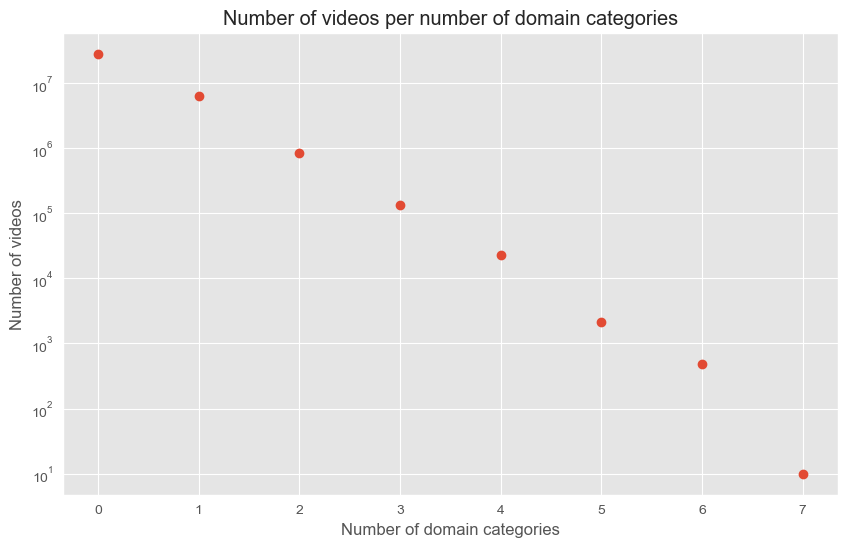

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(domain_categories_count['domain_categories_count'], domain_categories_count['count'], 'o')
plt.yscale('log')
plt.xlabel('Number of domain categories')
plt.ylabel('Number of videos')
plt.title('Number of videos per number of domain categories')
plt.show()

The **majority of videos are not classified as being sponsored by our model**, having no sponsored domains. A a vast majority of sponsored videos **tend to have only one sponsor**. This analysis has also been supported by the network analysis since sponsor nodes were mostly isolated.

In [18]:
video_categories = all_metadatas \
    .where(col('is_sponsored')) \
    .where(col('categories') != '') \
    .withColumn('domain_category', explode('domain_categories')) \
    .groupby('categories', 'domain_category') \
    .count() \
    .orderBy('count', ascending=False) \
    .toPandas()

In [19]:
video_categories = video_categories.set_index('categories') \
    .pivot(columns='domain_category', values='count')

video_categories_count = video_categories \
    .sum(axis=1) \
    .sort_values(ascending=True) \
    .to_frame() \

video_categories_top = video_categories.apply(lambda x: x.sort_values(ascending=False).head(3), axis=1) \
    .reindex(video_categories.sum(axis=1).sort_values(ascending=True).index)

In [20]:
video_categories_top.head()

domain_category,Agency,Application,Beauty,Education,Media,Music,Service,Shop,Travel,Vehicle,Video Game
categories,,,,,,,,,,,
Nonprofits & Activism,2544.0,4484.0,NaN,1033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pets & Animals,13033.0,4340.0,NaN,NaN,NaN,NaN,4897.0,NaN,NaN,NaN,NaN
Travel & Events,13958.0,6739.0,NaN,NaN,NaN,NaN,NaN,NaN,9444.0,NaN,NaN
Comedy,23606.0,13762.0,NaN,NaN,NaN,NaN,NaN,9482.0,NaN,NaN,NaN
Autos & Vehicles,39403.0,NaN,NaN,NaN,NaN,NaN,NaN,16288.0,NaN,19282.0,NaN


In [21]:
video_categories_count.head()

,0
categories,
Nonprofits & Activism,11370.0
Pets & Animals,32568.0
Travel & Events,59107.0
Comedy,76355.0
Autos & Vehicles,109685.0


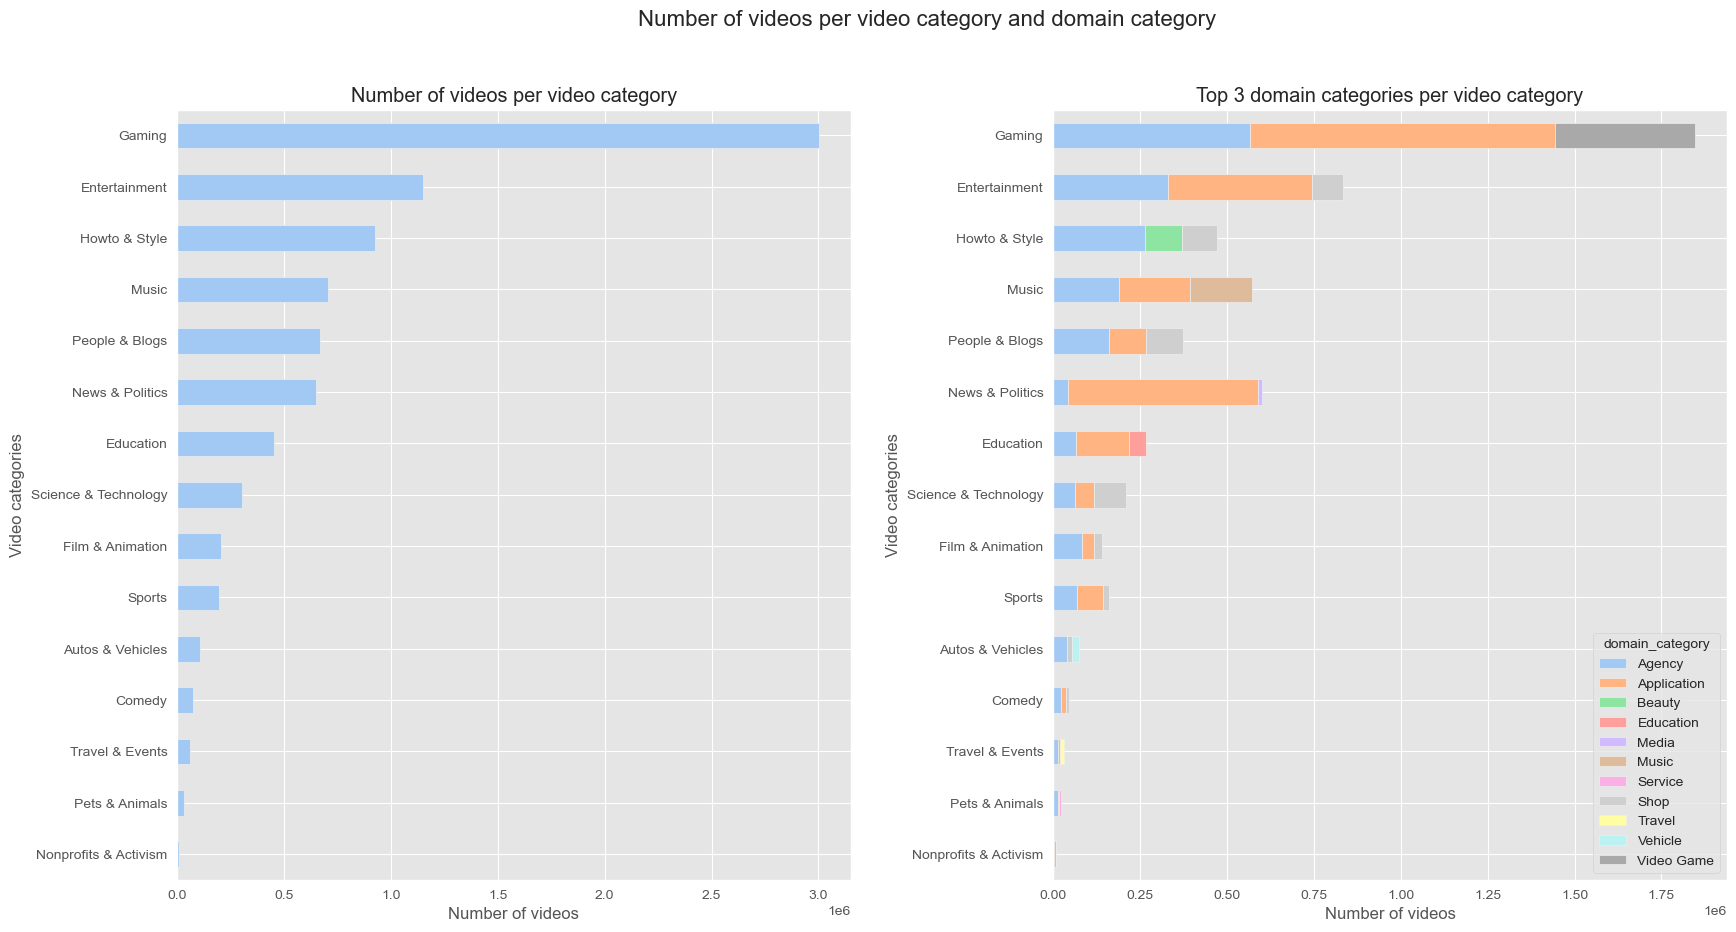

In [22]:
colors = sns.color_palette('pastel') + ['#A9A9A9']

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

video_categories_count.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlabel('Number of videos')
ax1.set_ylabel('Video categories')
ax1.set_title('Number of videos per video category')
ax1.get_legend().remove()

video_categories_top.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Number of videos')
ax2.set_ylabel('Video categories')
ax2.set_title('Top 3 domain categories per video category')

fig.suptitle('Number of videos per video category and domain category', fontsize=16)
fig.subplots_adjust(wspace=0.3)
plt.show()

The plot on the left shows us the number of sponsored videos per video category. We can see that `Gaming` is the most sponsored category of videos, followed by `Entertainment` and `Howto & Style`. 

The plot on the right shows us more information about the sponsor categories for each video category. Indeed, we can see that many videos are sponsored by `Applications` and all of them by `Agencies`. 
It is easy to spot that the video category and sponsor categories are related: the `Gaming` video category is mainly sponsored by `Video Game` sponsors which makes sense. `Entertainment` and `Howto & Style` are sponsored by `Shops`.

Also, `Howto & Style` and `People & Blogs` have suprisingly few sponsored videos on the second graph. This might indicate that these categories have a more diverse, uniform network of sponsors as many other categories not shown on this graph might be sponsoring them.

In [23]:
video_categories_total_count = all_metadatas \
    .select("categories") \
    .groupBy("categories") \
    .count() \
    .toPandas() \
    .set_index('categories') \
    .to_dict()['count']

In [24]:
video_categories_count_norm = video_categories_count \
    .apply(lambda x: x / video_categories_total_count[x.name], axis=1) \
    .sort_values(by=0, ascending=True)

In [25]:
video_categories_count_norm.head()

,0
categories,
Nonprofits & Activism,0.029495
Sports,0.101279
Autos & Vehicles,0.107100
Pets & Animals,0.132863
Travel & Events,0.133789


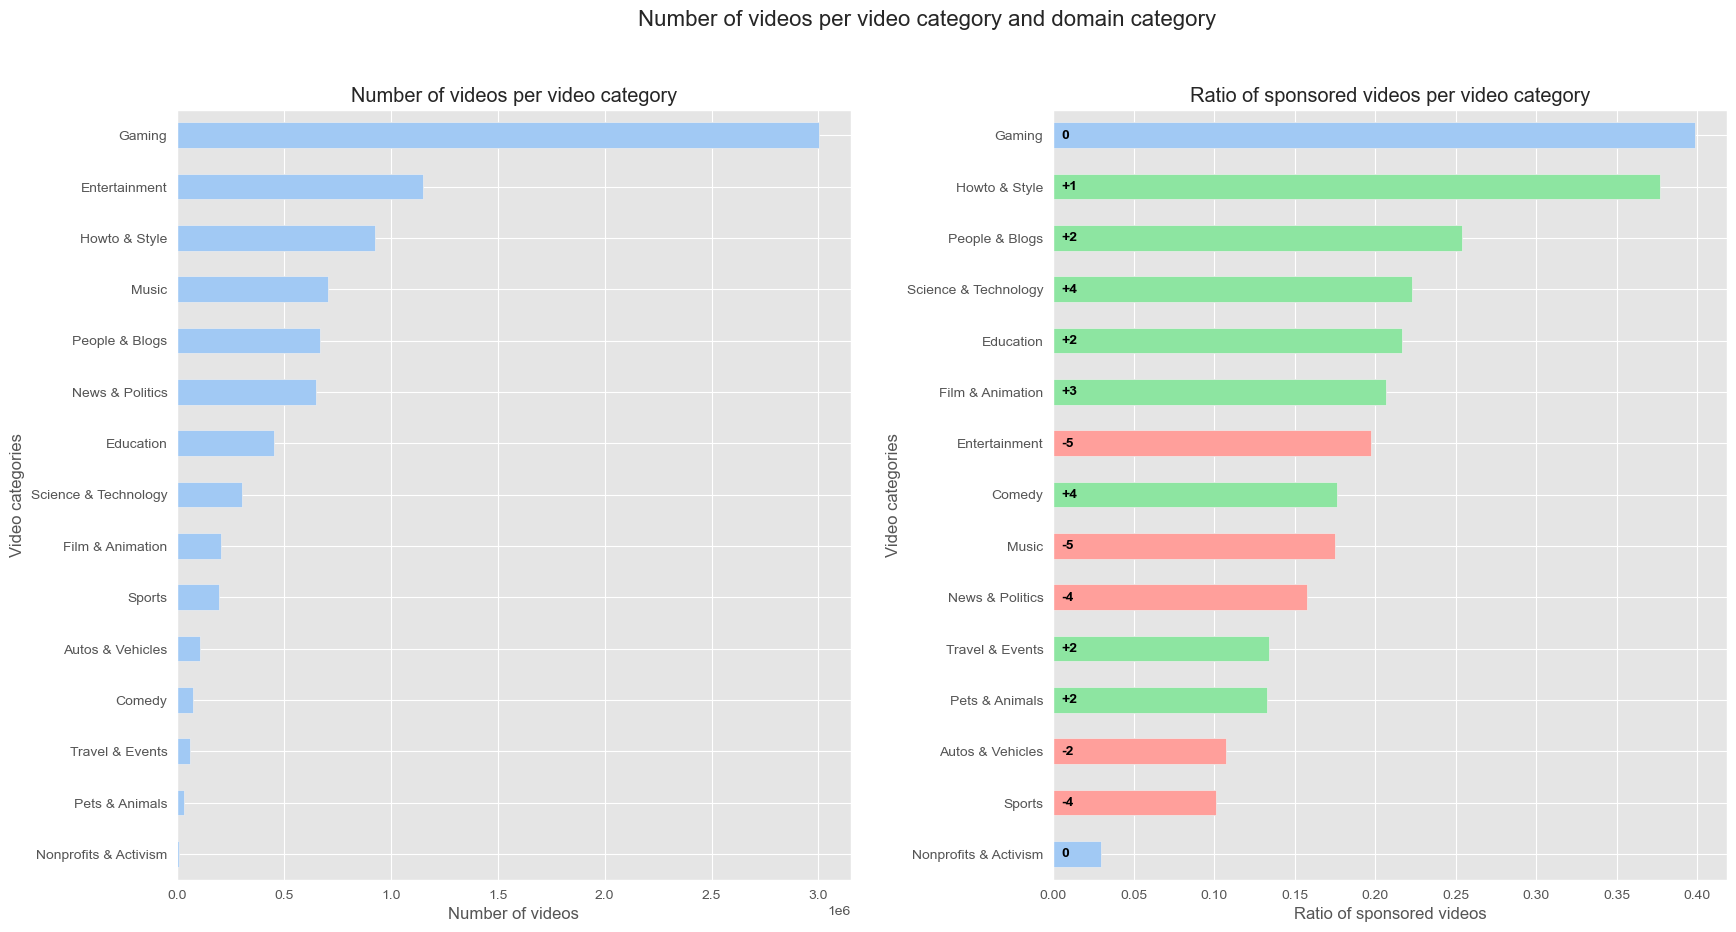

In [26]:
colors = sns.color_palette('pastel') + ['#A9A9A9']

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

video_categories_count.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlabel('Number of videos')
ax1.set_ylabel('Video categories')
ax1.set_title('Number of videos per video category')
ax1.get_legend().remove()

video_categories_count_norm.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Ratio of sponsored videos')
ax2.set_ylabel('Video categories')
ax2.set_title('Ratio of sponsored videos per video category')
ax2.get_legend().remove()

# Add ranking number of previous graph
ranking = video_categories_count[0].rank(ascending=False).astype(int).to_dict()
ranking_norm = video_categories_count_norm[0].rank(ascending=False).astype(int).to_dict()
for i, v in enumerate(video_categories_count_norm.index):
    diff = ranking[v] - ranking_norm[v]
    # Show difference between ranking
    ax2.text(0.005, i, '+'+str(diff) if diff > 0 else str(diff), color='black', va='center', fontweight='bold')
    # Change bar color depending on ranking difference
    if diff > 0:
        ax2.patches[i].set_facecolor(colors[2])
    elif diff < 0:
        ax2.patches[i].set_facecolor(colors[3])
    else:
        ax2.patches[i].set_facecolor(colors[0])

fig.suptitle('Number of videos per video category and domain category', fontsize=16)
fig.subplots_adjust(wspace=0.3)
plt.show()

The graph above shows a comparison on the number of videos per category and the ratio of sponsored videos per category. We can see that `Gaming` stays in the lead with about $40\%$ of sponsored videos. `Howto & Style` also has a high ratio of sponsored videos, but `Nonprofits & Activism` stays in the last position with very few sponsored videos.

The ratio of sponsored videos per category gives us better reasoning about the sponsorship of videos since categories are not equally represented in the dataset. We still get the same conclusion as before for some categories such as `Gaming` and `Nonprofits & Activism`, but some categories such as `Howto & Style` and `Science & Technology` come out as more sponsored than `Entertainment` and `Music`, which is quite different on the first graph.

### Sponsored vs Non-Sponsored Videos

#### Bootstrap Analysis on Features

We first apply a bootstrap analysis on the features of sponsored and non-sponsored videos.

In [27]:
all_metadatas = all_metadatas \
    .withColumn('like_view_ratio', col('like_count') / col('view_count')) \
    .withColumn('dislike_view_ratio', col('dislike_count') / col('view_count')) \
    .withColumn('like_dislike_ratio', col('like_count') / col('dislike_count'))

all_metadatas = all_metadatas \
    .where(col('like_view_ratio').isNotNull()) \
    .where(col('dislike_view_ratio').isNotNull()) \
    .where(col('like_dislike_ratio').isNotNull())

In [28]:
def bootstrap(df, column, n_bootstrap=1000, alpha=0.05, is_spark=True):
    # Get distribution values
    if is_spark:
        values = df.select(column).rdd.flatMap(lambda x: x).collect()
    else:
        values = df[column].values
    values_list = []
    values = [x for x in values if x is not None]
    n_samples = len(values)
    for i in tqdm(range(n_bootstrap)):
        values_list.append(np.mean(np.random.choice(values, n_samples, replace=True)))

    # GET CI
    values_list.sort()
    lower = int(n_bootstrap * alpha / 2)
    upper = int(n_bootstrap * (1 - alpha / 2))
    return values_list, values_list[lower], values_list[upper]

In [20]:
all_metadatas_sp = all_metadatas.where(col('is_sponsored'))
all_metadatas_nsp = all_metadatas.where(~col('is_sponsored'))

bootstrap_results = {}
bootstrap_feature_list = ['view_count', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
n_bootstrap = 1000
for feature in bootstrap_feature_list:
    bootstrap_sp, ci_sp_lower, ci_sp_upper = bootstrap(all_metadatas_sp, feature, n_bootstrap=n_bootstrap)
    bootstrap_nsp, ci_nsp_lower, ci_nsp_upper = bootstrap(all_metadatas_nsp, feature, n_bootstrap=n_bootstrap)
    # Write results to a dict
    bootstrap_results[feature] = {
        'sp': {
            'values': bootstrap_sp,
            'ci_lower': ci_sp_lower,
            'ci_upper': ci_sp_upper
        },
        'nsp': {
            'values': bootstrap_nsp,
            'ci_lower': ci_nsp_lower,
            'ci_upper': ci_nsp_upper
        }
    }

100%|██████████| 1000/1000 [16:25<00:00,  1.01it/s]


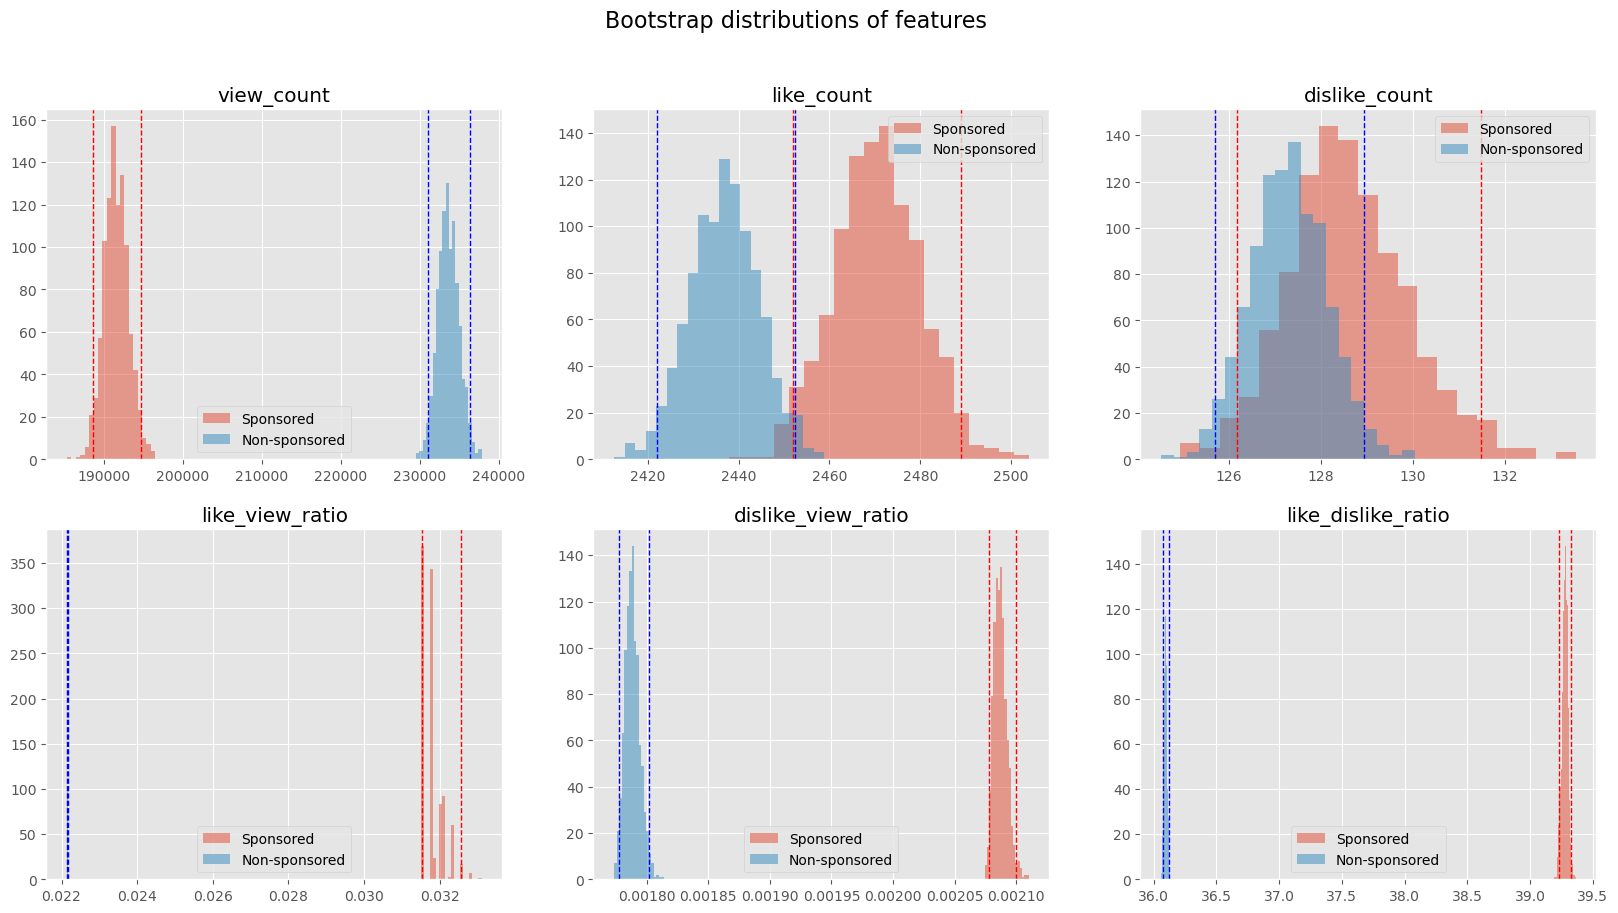

In [21]:
# plot histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(bootstrap_feature_list):
    ax = axes[i // 3, i % 3]
    ax.hist(bootstrap_results[feature]['sp']['values'], bins=20, alpha=0.5, label='Sponsored')
    ax.hist(bootstrap_results[feature]['nsp']['values'], bins=20, alpha=0.5, label='Non-sponsored')
    ax.axvline(bootstrap_results[feature]['sp']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['sp']['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_lower'], color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_upper'], color='blue', linestyle='dashed', linewidth=1)
    ax.set_title(feature)
    ax.legend()
fig.suptitle('Bootstrap distributions of features', fontsize=16)
plt.show()

The graph above shows the distributions of the mean of features using bootstrap analysis for some features related to the popularity and the appreciation of videos. Interestingly, the first plot shows us that **sponsored video tend to have a lower number of views than non-sponsored videos**, about $15\%$ less! Nevertheless, sponsored videos tend to have a **higher reaction count**, with more like and dislikes on average than non-sponsored videos. The ratio of likes to dislikes is also higher for sponsored videos!

The first result is quite surprising since we would expect sponsored videos to have a higher number of views as sponsors may target videos with a higher potential of being popular. But this result may be explained by the fact that many confounding factors may influence the popularity of a video in each group. For example, non-sponsored videos might consist in many music videos, which tend to have a huge view count as they are listened to by many people and automatic playlists multiple times. Also, media channels might publish unsponsored videos with a high view count.

The second finding could be expected, but might also be explained by external factors. For example the Gaming industry, dominating sponsored videos from our past findings, might be more competitive than others video categories. They might ask for more engagement and form strong communities around their content, asking for likes and reactions. The like to view and dislike to view rations might be higher for that reason.

### T-tests

In [22]:
# Apply t-tests for each feature
ttest_results = {}
for feature in bootstrap_feature_list:
    ttest_results[feature] = ttest_ind(
        bootstrap_results[feature]['sp']['values'],
        bootstrap_results[feature]['nsp']['values'],
        equal_var=False
    )

# print results
for feature in bootstrap_feature_list:
    print(f'{feature}: {ttest_results[feature]}')

view_count: Ttest_indResult(statistic=-650.6261659967737, pvalue=0.0)
like_count: Ttest_indResult(statistic=87.61528983510382, pvalue=0.0)
dislike_count: Ttest_indResult(statistic=26.4048332691145, pvalue=7.84949660855777e-129)
like_view_ratio: Ttest_indResult(statistic=1120.9452322288612, pvalue=0.0)
dislike_view_ratio: Ttest_indResult(statistic=1154.8658549256202, pvalue=0.0)
like_dislike_ratio: Ttest_indResult(statistic=3788.1834709499617, pvalue=0.0)


The t-tests also show us that **sponsored and non-sponsored videos have significant differences on the analysed features**. The p-values are almost all equal to $0$, meaning that we can reject the null hypothesis that the means of the two groups are equal.

### Matching Analysis on Sponsored Videos

To avoid the possible bias caused by confounding factors in our previous analysis, we perform a matching analysis. We match sponsored and non-sponsored videos based on some rules:

- The videos should have the same category.
- The videos should not come from the same channel.
- The videos should have the same order of magnitude of views.
- The videos should be posted on the same month.
- The videos should have the same approximate length ($10$ minutes difference maximum).

We perform our analysis on a random sample of $1\%$ of the entire dataset.

In [20]:
SAMPLE_FRACTION = 0.01
SAMPLE_SEED = 0

# Generate the subsample
all_metadatas_sub = all_metadatas \
    .sample(False, SAMPLE_FRACTION, seed=SAMPLE_SEED) \
    .select('categories', 'channel_id', 'view_count', 'diff_month', 'duration', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio', 'is_sponsored') \
    .toPandas()

In [22]:
DURATION_BIN_SIZE = 60 * 10

G = nk.graph.Graph(n=len(all_metadatas_sub), weighted=False, directed=False)

# Add edges on non-sponsored exact matches for every sponsored video
for sp_id, sp_row in tqdm(all_metadatas_sub[all_metadatas_sub.is_sponsored].iterrows()):
    category = sp_row['categories']
    channel_id = sp_row['channel_id']
    log_view_count = np.floor(np.log(sp_row['view_count']))
    diff_month = sp_row['diff_month']
    duration = sp_row['duration']
    exact_matched = all_metadatas_sub[
        (all_metadatas_sub.categories == category) &
        (all_metadatas_sub.channel_id != channel_id) &
        (np.floor(np.log(all_metadatas_sub.view_count)) == log_view_count) &
        (all_metadatas_sub.diff_month == diff_month) &
        (np.abs(all_metadatas_sub.duration - duration) < DURATION_BIN_SIZE) &
        (~all_metadatas_sub.is_sponsored)
    ]
    for nps_id, nsp_row in exact_matched.iterrows():
        G.addEdge(sp_id, nps_id)

57468it [18:42, 51.21it/s]


In [23]:
print(f'Number of nodes: {G.numberOfNodes()}')
print(f'Number of edges: {G.numberOfEdges()}')

Number of nodes: 256159
Number of edges: 1679887


In [24]:
# Perform a linear time 1/2-approximation of the maximum matching.
matcher = nk.matching.PathGrowingMatcher(G).run()
matching = matcher.getMatching()

In [25]:
matching_pairs = []
for u in G.iterNodes():
    if matching.isMatched(u) and u < matching.mate(u):
        matching_pairs.append((u, matching.mate(u)))
len(matching_pairs)

45656

In [31]:
# Get a new dataframe with the matched pairs
matching_df = pd.DataFrame(matching_pairs, columns=['sp_id', 'nsp_id'])
matching_df = matching_df.merge(all_metadatas_sub, left_on='sp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .merge(all_metadatas_sub, left_on='nsp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .drop(['sp_id', 'nsp_id'], axis=1)

# Separate the matched pairs
all_matching = np.asarray([[m[0], m[1]] for m in matching_pairs]).flatten().tolist()
all_matching_df = all_metadatas_sub[all_metadatas_sub.index.isin(all_matching)].copy()
all_matching_df['is_sponsored'] = all_matching_df['is_sponsored'].astype(int)

all_matching_df

,categories,channel_id,view_count,diff_month,duration,like_count,dislike_count,like_view_ratio,dislike_view_ratio,like_dislike_ratio,is_sponsored
1,Entertainment,UCjWIUN8EfDV5b09FHMngD0A,50953,155,1700,2802,48,0.054992,0.000942,58.375000,0
5,Entertainment,UCGydrkfIhUDNCotYQI8TJhA,43817,135,93,152,42,0.003469,0.000959,3.619048,0
6,News & Politics,UC3k3floOm_HtKOv0l6JU-xQ,2269,139,354,70,2,0.030851,0.000881,35.000000,0
8,Gaming,UCsDtTzkvGxxw95C4IOfZ7dw,101313,124,1974,2467,55,0.024350,0.000543,44.854545,1
9,News & Politics,UCl5YgCiwSRVOiC2Nd1P9v1A,9781,168,303,92,12,0.009406,0.001227,7.666667,0
...,...,...,...,...,...,...,...,...,...,...,...
256115,Entertainment,UCnkQvzIGTYodVwU9BLnYWWA,508,168,213,22,1,0.043307,0.001969,22.000000,1
256119,Music,UCaOWPFOz0xlEN6z4a7RNT5g,3303,105,148,26,3,0.007872,0.000908,8.666667,1
256133,Gaming,UCRziS4QyZ1VZIfeolPcOS5A,4124,148,219,56,9,0.013579,0.002182,6.222222,1
256146,Sports,UCV_kZ4gveK8fVEfTWWVGSgw,102908,145,446,368,246,0.003576,0.002390,1.495935,1


like_count:
	Intercept: 1559.075017522343 with p-value 0.0
	Sponsored: 123.28123357280742 with p-value 0.023059436068326777
	R-squared: 5.655354695610626e-05
dislike_count:
	Intercept: 70.77832048361633 with p-value 3.042690374320046e-36
	Sponsored: 9.031868757666016 with p-value 0.2564542786032538
	R-squared: 1.4103551238098255e-05
like_view_ratio:
	Intercept: 0.026331118989094827 with p-value 0.0
	Sponsored: 0.004375507199508967 with p-value 1.1427541578720109e-140
	R-squared: 0.006957918255264817
dislike_view_ratio:
	Intercept: 0.001614170867591669 with p-value 0.0
	Sponsored: 0.00023382121688327392 with p-value 3.011788795650553e-18
	R-squared: 0.0008306931371387938
like_dislike_ratio:
	Intercept: 40.136783421314064 with p-value 0.0
	Sponsored: 0.6689996463788273 with p-value 0.06879459507076298
	R-squared: 3.626664802869328e-05


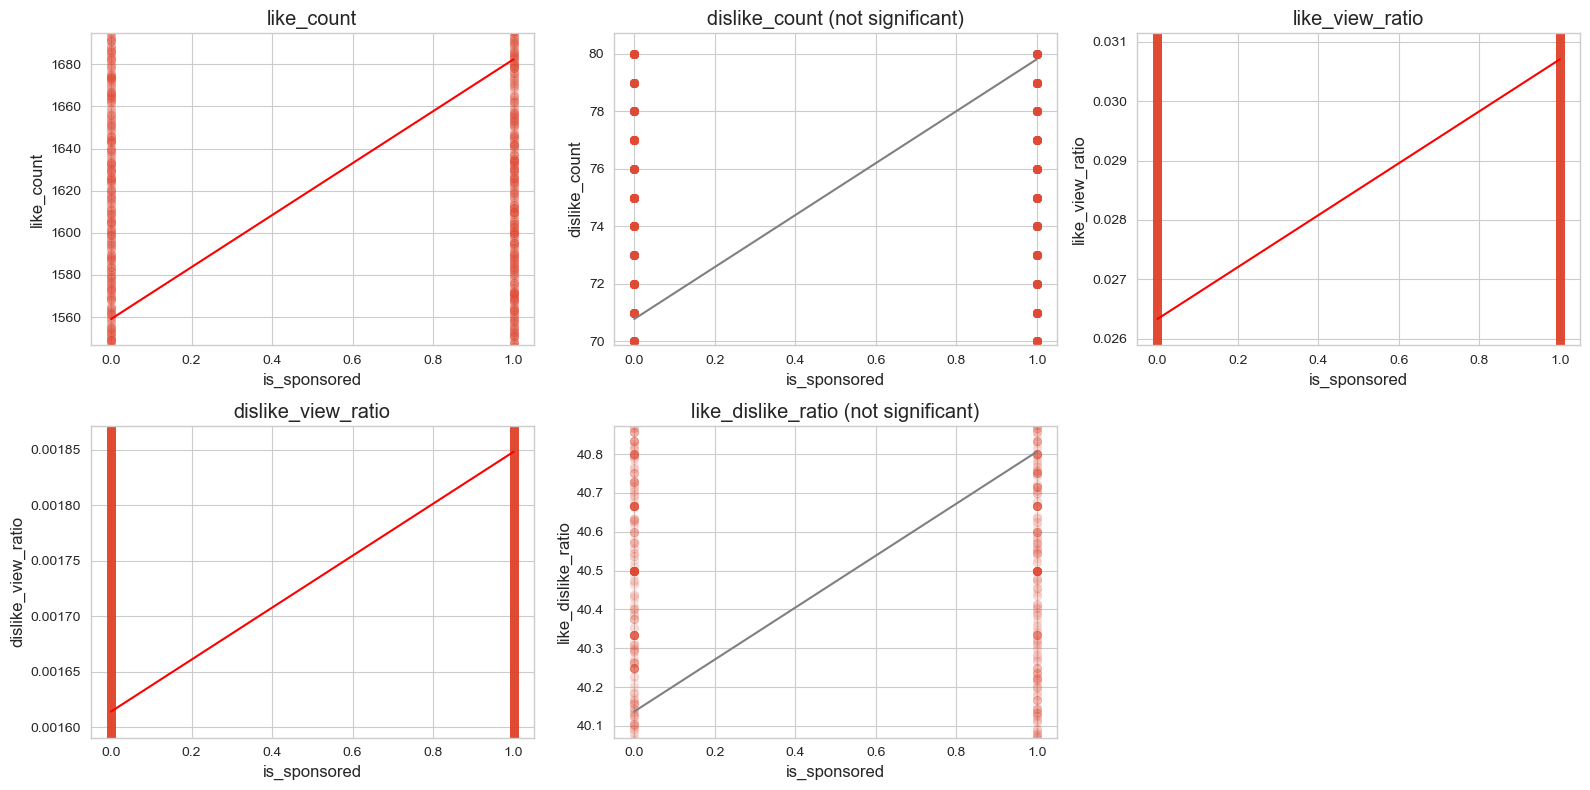

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

feature_list = ['like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
for i, feature in enumerate(feature_list):
    mod = smf.ols(formula=f'{feature} ~ C(is_sponsored)', data=all_matching_df)
    res = mod.fit()
    print(f'{feature}:')
    print(f'\tIntercept: {res.params[0]} with p-value {res.pvalues[0]}')
    print(f'\tSponsored: {res.params[1]} with p-value {res.pvalues[1]}')
    print(f'\tR-squared: {res.rsquared}')

    ax = axes[i // 3, i % 3]
    X = [0, 1]
    y = [res.params[0], res.params[0] + res.params[1]]
    ax.plot(X, y, color='red' if res.pvalues[1] < 0.05 else 'gray')
    ax.scatter(all_matching_df['is_sponsored'], all_matching_df[feature], alpha=0.1)
    ax.set_title(feature)
    ax.set_xlabel('is_sponsored')
    ax.set_ylabel(feature)
    # zoom only on interesting parts
    y_1 = res.params[0] - res.params[1] / 10
    y_2 = res.params[0] + res.params[1] + res.params[1] / 10
    ax.set_ylim(min(y_1, y_2), max(y_1, y_2))
    if res.pvalues[1] > 0.05:
        ax.set_title(feature + ' (not significant)')

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


Finally, we perform a regression analysis on the matched elements. The results are shown above. The `like_count` has an intercept of $1559$, which means that the mean of the number of likes for non-sponsored videos is $1559$. Sponsored users have $123$ more likes on average, with statistical significance! In this analysis, we also conclude that **sponsored videos have a higher number of likes**.

But we were not able to conclude anything about the number of dislikes. Indeed, non-sponsored videos have about $70$ dislikes, but the slope of the regression is not significant. This might be explained by the fact that the number of dislikes is very low for both groups, and the confidence interval is very large.

The ratio of likes per view seem to be higher for sponsored videos, sponsored videos have on average an increase of $\frac{0.0043}{0.0263} * 100 = 16\%$ of likes per view, with statistical significance.

Interestingly enough, the number of dislikes per view is also higher for sponsored videos, with an increase of $\frac{0.00023}{0.0016} * 100 = 14\%$ of dislikes per view, with statistical significance.

This could be explained by two things: 
- In the matching, we matched videos with the same order of magnitude of views, but in our previous analysis, we saw that sponsored videos had on average a lower number of views. This tendency could also slightly appear in this analysis, which would explain the increase of likes and dislikes per view.
- The second explanation would be that sponsored videos are more engaging towards the audience. Sponsored YouTubers might ask for more likes and reactions as their revenue is based on the popularity of their videos.

We will check if the first explanation is true using a bootrapping approach.

100%|██████████| 10000/10000 [00:13<00:00, 745.15it/s]


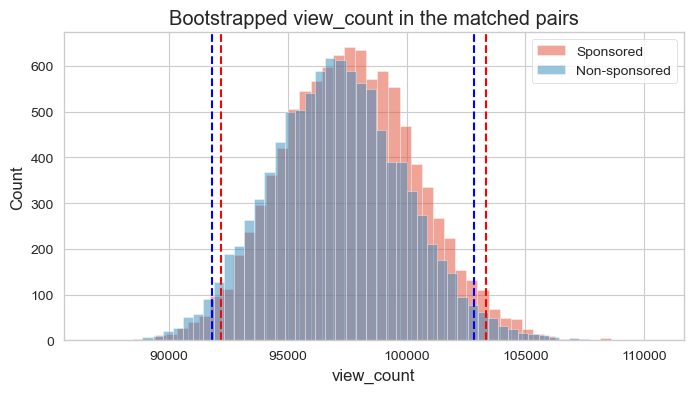

In [63]:
all_matching_sp = all_matching_df[all_matching_df.is_sponsored == 1]
all_matching_nsp = all_matching_df[all_matching_df.is_sponsored == 0]

# Bootstrap
n_bootstrap = 10000
bootstrap_sp, ci_sp_lower, ci_sp_upper = bootstrap(all_matching_sp, 'view_count', n_bootstrap=n_bootstrap, is_spark=False)
bootstrap_nsp, ci_nsp_lower, ci_nsp_upper = bootstrap(all_matching_nsp, 'view_count', n_bootstrap=n_bootstrap, is_spark=False)

# Plot histograms
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(bootstrap_sp, bins=50, alpha=0.5, label='Sponsored')
ax.hist(bootstrap_nsp, bins=50, alpha=0.5, label='Non-sponsored')
ax.axvline(ci_sp_lower, color='red', linestyle='--')
ax.axvline(ci_sp_upper, color='red', linestyle='--')
ax.axvline(ci_nsp_lower, color='blue', linestyle='--')
ax.axvline(ci_nsp_upper, color='blue', linestyle='--')
ax.set_title('Bootstrapped view_count in the matched pairs')
ax.set_xlabel('view_count')
ax.set_ylabel('Count')
ax.legend()
plt.show()

The matching captured an interesting finding, since both sponsored and non-sponsored seem to follow a very similar trend: the first explanation seems to be false!

In [67]:
bootstrap_results = {}
bootstrap_feature_list = ['view_count', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
n_bootstrap = 10000
for feature in bootstrap_feature_list:
    bootstrap_sp, ci_sp_lower, ci_sp_upper = bootstrap(all_matching_sp, feature, n_bootstrap=n_bootstrap, is_spark=False)
    bootstrap_nsp, ci_nsp_lower, ci_nsp_upper = bootstrap(all_matching_nsp, feature, n_bootstrap=n_bootstrap, is_spark=False)
    # Write results to a dict
    bootstrap_results[feature] = {
        'sp': {
            'values': bootstrap_sp,
            'ci_lower': ci_sp_lower,
            'ci_upper': ci_sp_upper
        },
        'nsp': {
            'values': bootstrap_nsp,
            'ci_lower': ci_nsp_lower,
            'ci_upper': ci_nsp_upper
        }
    }

100%|██████████| 10000/10000 [00:13<00:00, 722.79it/s]


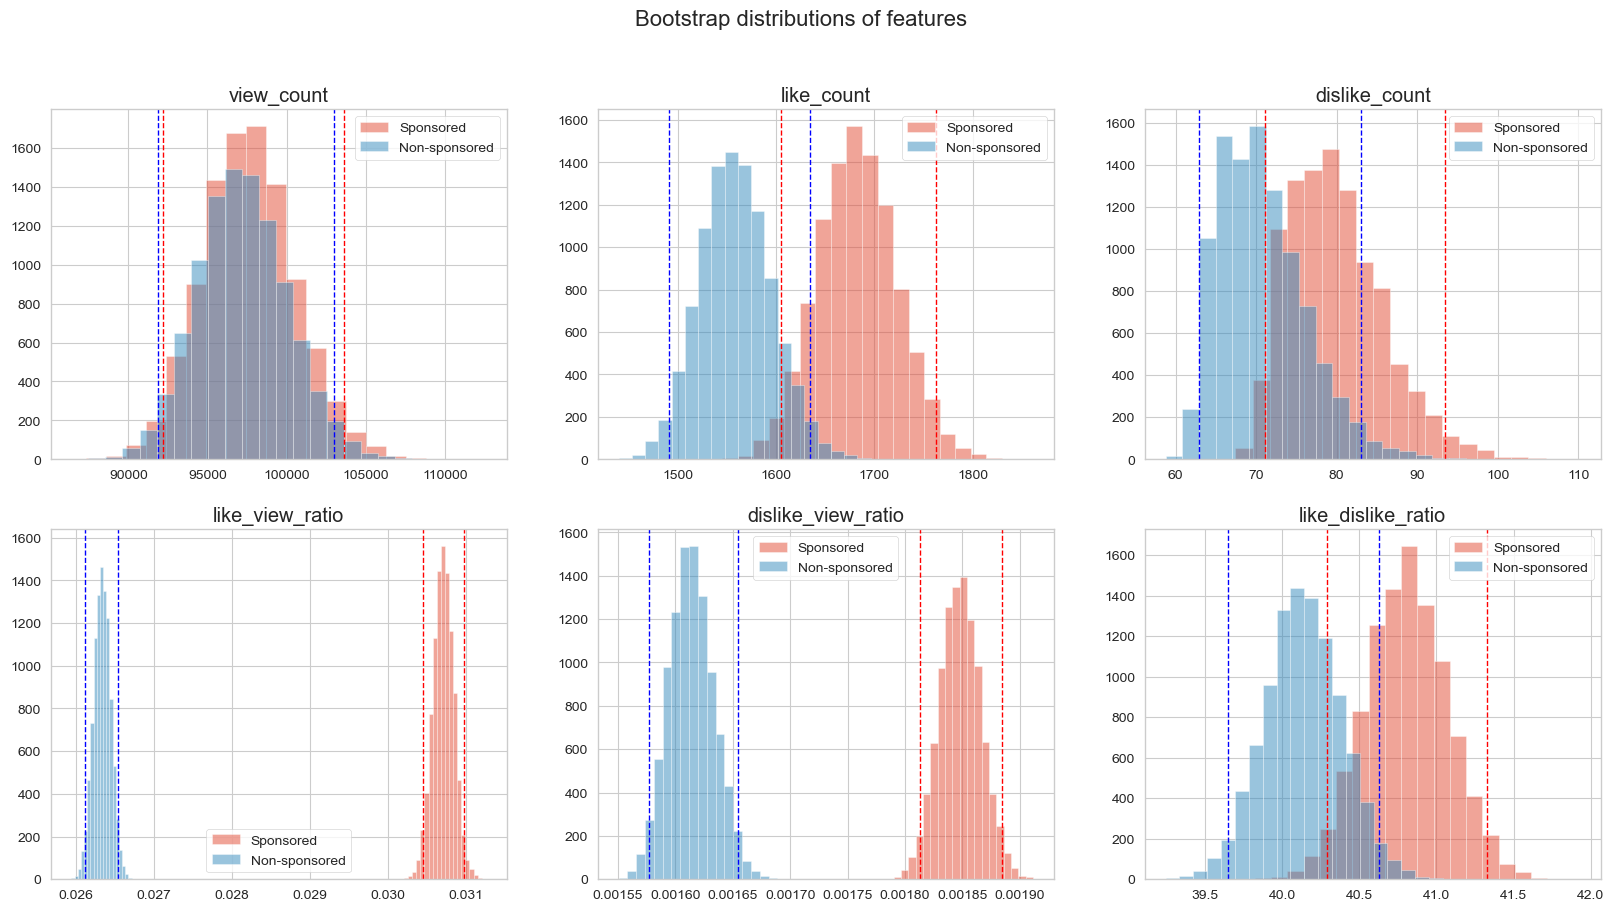

In [68]:
# plot histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(bootstrap_feature_list):
    ax = axes[i // 3, i % 3]
    ax.hist(bootstrap_results[feature]['sp']['values'], bins=20, alpha=0.5, label='Sponsored')
    ax.hist(bootstrap_results[feature]['nsp']['values'], bins=20, alpha=0.5, label='Non-sponsored')
    ax.axvline(bootstrap_results[feature]['sp']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['sp']['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_lower'], color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nsp']['ci_upper'], color='blue', linestyle='dashed', linewidth=1)
    ax.set_title(feature)
    ax.legend()
fig.suptitle('Bootstrap distributions of features', fontsize=16)
plt.show()

This plot shows the same histograms as before, but only taking into account the matched videos. The `view_count` is similar since it appears in our exact matching rules, and the confidence intervals show us approximately the same results as before. We can see that both confidence intervals for the `dislike_count` are overlapping, but we can still notice a trend: the number of dislikes seems to be higher for sponsored videos. 

### Matching Analysis on Agencies

In this section, we perform the same analysis steps as before, but focusing on the agencies. We match videos sponsored by agencies and sponsored videos that are not sponsored by agencies. We perform our analysis on a random sample of $2\%$ of the entire dataset.

In [31]:
SAMPLE_FRACTION = 0.02
SAMPLE_SEED = 0

# Generate the subsample
all_metadatas_sub = all_metadatas \
    .sample(False, SAMPLE_FRACTION, seed=SAMPLE_SEED) \
    .select('categories', 'channel_id', 'view_count', 'diff_month', 'duration', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio', 'domain_categories', 'is_sponsored') \
    .toPandas()

# Add has_agency feature
all_metadatas_sub['has_agency'] = all_metadatas_sub.apply(lambda row: 'Agency' in row['domain_categories'], axis=1)
all_metadatas_sub = all_metadatas_sub.drop(['domain_categories'], axis=1)

In [32]:
DURATION_BIN_SIZE = 60 * 10

G = nk.graph.Graph(n=len(all_metadatas_sub), weighted=False, directed=False)

# Add edges on non-sponsored exact matches for every sponsored video
for sp_id, sp_row in tqdm(all_metadatas_sub[all_metadatas_sub.has_agency].iterrows()):
    channel_id = sp_row['channel_id']
    log_view_count = np.floor(np.log(sp_row['view_count']))
    diff_month = sp_row['diff_month']
    duration = sp_row['duration']
    exact_matched = all_metadatas_sub[
        (all_metadatas_sub.channel_id != channel_id) &
        (np.floor(np.log(all_metadatas_sub.view_count)) == log_view_count) &
        (all_metadatas_sub.diff_month == diff_month) &
        (np.abs(all_metadatas_sub.duration - duration) < DURATION_BIN_SIZE) &
        (~all_metadatas_sub.has_agency) &
        (all_metadatas_sub.is_sponsored)
    ]
    for nps_id, nsp_row in exact_matched.iterrows():
        G.addEdge(sp_id, nps_id)

31360it [11:38, 44.93it/s]


In [33]:
print(f'Number of nodes: {G.numberOfNodes()}')
print(f'Number of edges: {G.numberOfEdges()}')

Number of nodes: 511959
Number of edges: 3429744


In [34]:
# Perform a linear time 1/2-approximation of the maximum matching.
matcher = nk.matching.PathGrowingMatcher(G).run()
matching = matcher.getMatching()

In [35]:
matching_pairs = []
for u in G.iterNodes():
    if matching.isMatched(u) and u < matching.mate(u):
        matching_pairs.append((u, matching.mate(u)))
len(matching_pairs)

29019

In [36]:
# Get a new dataframe with the matched pairs
matching_df = pd.DataFrame(matching_pairs, columns=['sp_id', 'nsp_id'])
matching_df = matching_df.merge(all_metadatas_sub, left_on='sp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .merge(all_metadatas_sub, left_on='nsp_id', right_index=True, suffixes=('_sp', '_nsp')) \
    .drop(['sp_id', 'nsp_id'], axis=1)

# Separate the matched pairs
all_matching = np.asarray([[m[0], m[1]] for m in matching_pairs]).flatten().tolist()
all_matching_df = all_metadatas_sub[all_metadatas_sub.index.isin(all_matching)].copy()
all_matching_df['has_agency'] = all_matching_df['has_agency'].astype(int)

all_matching_df

,categories,channel_id,view_count,diff_month,duration,like_count,dislike_count,like_view_ratio,dislike_view_ratio,like_dislike_ratio,is_sponsored,has_agency
1,Music,UC5I3vUh2iNfQ3pCU3sodYRA,3799,160,2958,134,4,0.035272,0.001053,33.500000,True,0
12,Music,UCH8zETBh4ZBW8FSEObTpVGA,44312,148,202,811,11,0.018302,0.000248,73.727273,True,0
15,Gaming,UCsDtTzkvGxxw95C4IOfZ7dw,101313,124,1974,2467,55,0.024350,0.000543,44.854545,True,1
18,Music,UC22nIfOTM7KLIQuFGMKzQbg,547911,141,258,291,126,0.000531,0.000230,2.309524,True,0
26,Gaming,UCQpCAElRwC5kb6oyXoBxApw,1368,149,180,39,3,0.028509,0.002193,13.000000,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
511780,Entertainment,UC3ldAyWZqlLdSh5EyxX2EbQ,2196,161,949,249,1,0.113388,0.000455,249.000000,True,1
511797,Howto & Style,UCGIaiz5OLxlfuH9gkqbejnQ,195403,167,380,8010,123,0.040992,0.000629,65.121951,True,1
511839,Howto & Style,UCPKAKrjoMz7POptCloy7AIQ,29313,142,379,605,10,0.020639,0.000341,60.500000,True,1
511873,Music,UCaOWPFOz0xlEN6z4a7RNT5g,3303,105,148,26,3,0.007872,0.000908,8.666667,True,1


like_count:
	Intercept: 1867.2136186636665 with p-value 5.649729435926451e-198
	Agency: 195.85905785857835 with p-value 0.025409581566262763
	R-squared: 8.607729608434145e-05
dislike_count:
	Intercept: 84.92284365415891 with p-value 4.3391539943880096e-203
	Agency: -8.578276301736146 with p-value 0.029216009002074484
	R-squared: 8.192649701754817e-05
like_view_ratio:
	Intercept: 0.02845618213026577 with p-value 0.0
	Agency: 0.00790421013410051 with p-value 2.812391024998201e-258
	R-squared: 0.020102431363766327
dislike_view_ratio:
	Intercept: 0.0018099611007482213 with p-value 0.0
	Agency: -6.09413686414023e-05 with p-value 0.05508853812935607
	R-squared: 6.339718588987964e-05
like_dislike_ratio:
	Intercept: 38.06315645404012 with p-value 0.0
	Agency: 9.736438878143145 with p-value 1.8276578185222812e-94
	R-squared: 0.007299283307704574


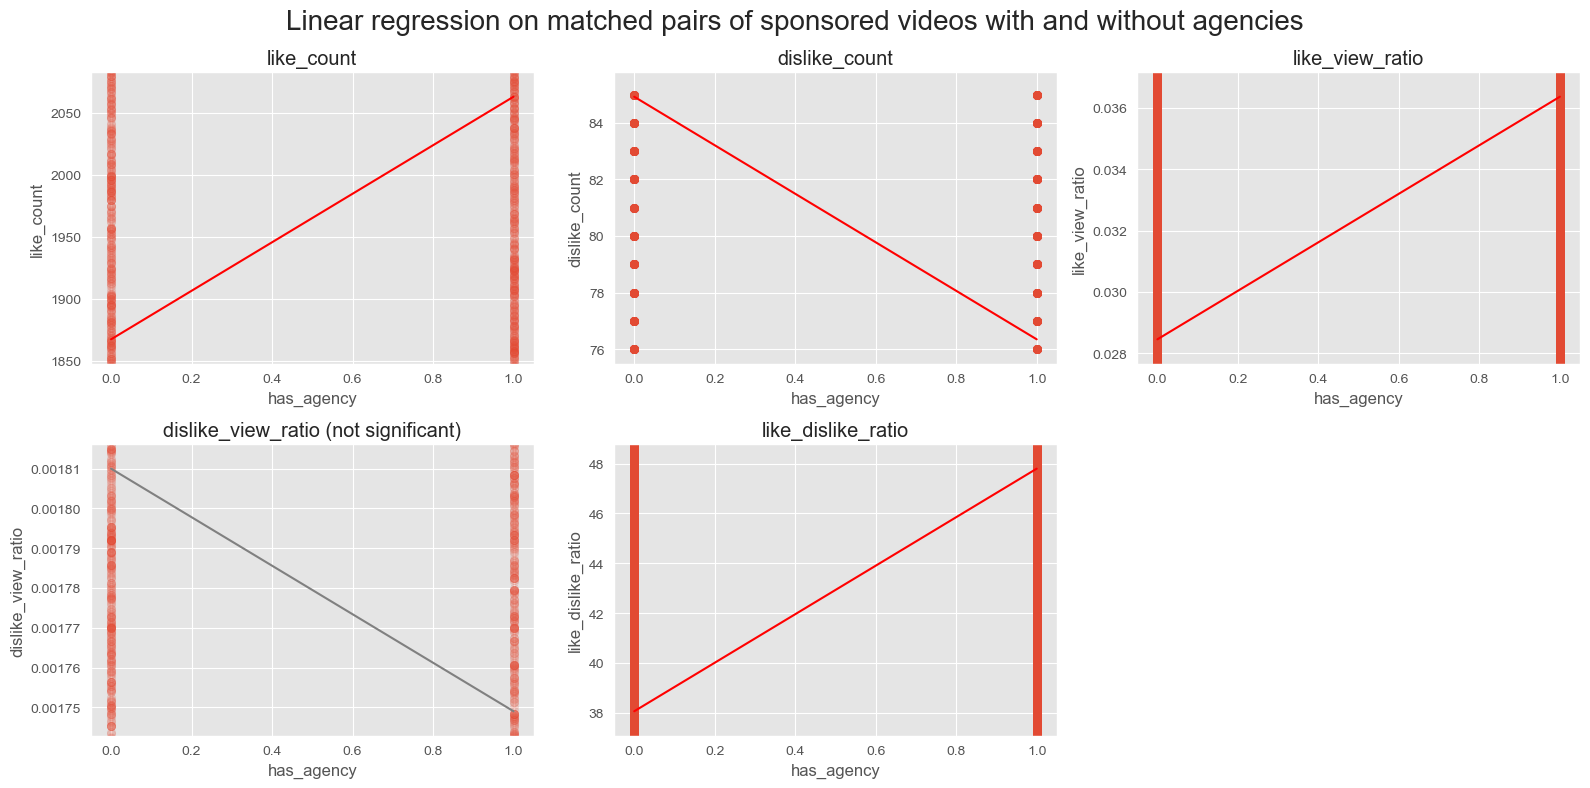

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

feature_list = ['like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
for i, feature in enumerate(feature_list):
    mod = smf.ols(formula=f'{feature} ~ C(has_agency)', data=all_matching_df)
    res = mod.fit()
    print(f'{feature}:')
    print(f'\tIntercept: {res.params[0]} with p-value {res.pvalues[0]}')
    print(f'\tAgency: {res.params[1]} with p-value {res.pvalues[1]}')
    print(f'\tR-squared: {res.rsquared}')

    ax = axes[i // 3, i % 3]
    X = [0, 1]
    y = [res.params[0], res.params[0] + res.params[1]]
    ax.plot(X, y, color='red' if res.pvalues[1] < 0.05 else 'gray')
    ax.scatter(all_matching_df['has_agency'], all_matching_df[feature], alpha=0.1)
    ax.set_title(feature)
    ax.set_xlabel('has_agency')
    ax.set_ylabel(feature)
    # zoom only on interesting parts
    y_1 = res.params[0] - res.params[1] / 10
    y_2 = res.params[0] + res.params[1] + res.params[1] / 10
    ax.set_ylim(min(y_1, y_2), max(y_1, y_2))
    if res.pvalues[1] > 0.05:
        ax.set_title(feature + ' (not significant)')

fig.delaxes(axes[1, 2])
fig.suptitle('Linear regression on matched pairs of sponsored videos with and without agencies', fontsize=20)
plt.tight_layout()
plt.show()


The above plots show the regression analysis on the matched elements. The treatment group is sponsored by an agency, whereas the control group is not. We can see that videos sponsored by agencies have a **higher number of likes and a lower number of dislikes**! They also have a **higher ratio of likes per view** and a **higher like/dislike ratio**.

All of these results are positive towards the videos sponsored by agencies. They seem to be more engaging, with a more likes and less dislikes. This could be explained by the fact that agencies are more professional and have more experience in the field of marketing and advertising. They might be able to target the right audience and create more engaging content.

In [38]:
all_matching_ag = all_matching_df[all_matching_df.has_agency == 1]
all_matching_nag = all_matching_df[all_matching_df.has_agency == 0]

bootstrap_results = {}
bootstrap_feature_list = ['view_count', 'like_count', 'dislike_count', 'like_view_ratio', 'dislike_view_ratio', 'like_dislike_ratio']
n_bootstrap = 10000
for feature in bootstrap_feature_list:
    bootstrap_ag, ci_ag_lower, ci_ag_upper = bootstrap(all_matching_ag, feature, n_bootstrap=n_bootstrap, is_spark=False)
    bootstrap_nag, ci_nag_lower, ci_nag_upper = bootstrap(all_matching_nag, feature, n_bootstrap=n_bootstrap, is_spark=False)
    # Write results to a dict
    bootstrap_results[feature] = {
        'ag': {
            'values': bootstrap_ag,
            'ci_lower': ci_ag_lower,
            'ci_upper': ci_ag_upper
        },
        'nag': {
            'values': bootstrap_nag,
            'ci_lower': ci_nag_lower,
            'ci_upper': ci_nag_upper
        }
    }

100%|██████████| 10000/10000 [00:07<00:00, 1252.16it/s]


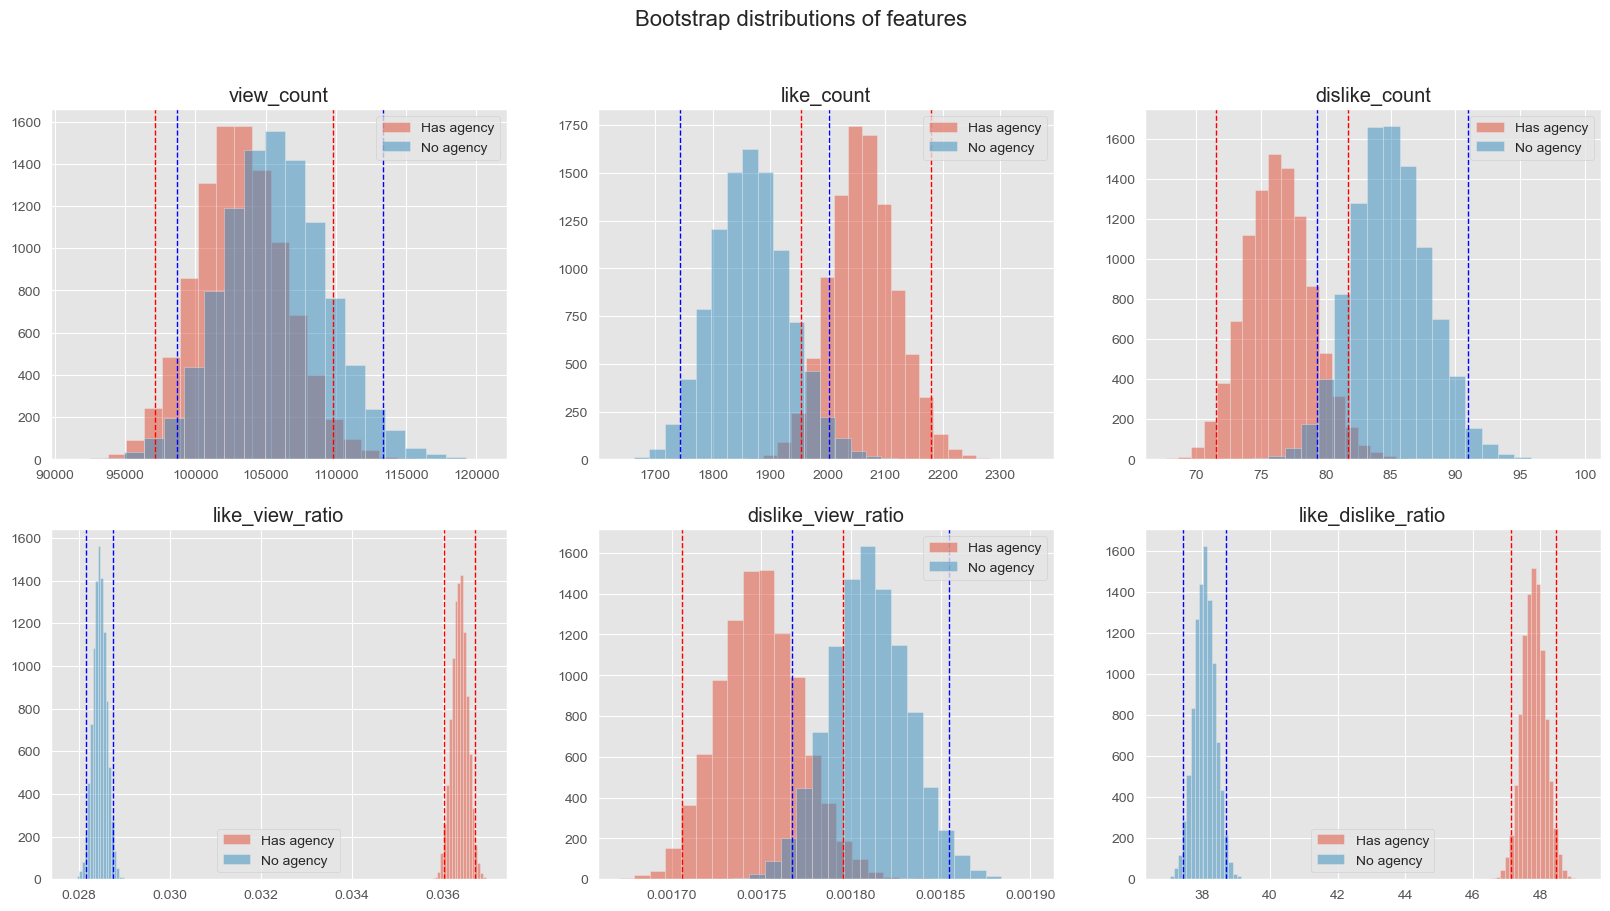

In [40]:
# plot histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, feature in enumerate(bootstrap_feature_list):
    ax = axes[i // 3, i % 3]
    ax.hist(bootstrap_results[feature]['ag']['values'], bins=20, alpha=0.5, label='Has agency')
    ax.hist(bootstrap_results[feature]['nag']['values'], bins=20, alpha=0.5, label='No agency')
    ax.axvline(bootstrap_results[feature]['ag']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['ag']['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nag']['ci_lower'], color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(bootstrap_results[feature]['nag']['ci_upper'], color='blue', linestyle='dashed', linewidth=1)
    ax.set_title(feature)
    ax.legend()
fig.suptitle('Bootstrap distributions of features', fontsize=16)
plt.show()

This plot shows the same histograms as before, taking into account the matched sponsored videos with and without agencies. Comparing the two, the like to dislike ratio seems to be approximately the same, but videos with agencies have less dislikes with statistical significance. The dislike to view ratio emphasizes the same conclusion, with a lower ratio for videos with agencies.

Also, the like to dislike ration are completely different, with videos agencies having an increase of $1 - \frac{46}{36} * 100 = 28\%$ of likes per dislike, with statistical significance. 